In [8]:
from scipy import io
from scipy.signal import butter, lfilter, resample

import h5py
import random
import numpy as np
import os

from nd_legacy import *

In [9]:
datafolder = "data/sample/ksenia_long/"

In [10]:
train_datas = {}
val_datas = {}
test_datas = {}

def to_onehot(label):
    labels_encoding = {1: np.array([1,0,0]), 2: np.array([0,1,0]), 6: np.array([0,0,1])}
    return labels_encoding[label]

for fname in os.listdir(datafolder):
    filename = datafolder + fname
    [eeg_data, states_labels, sampling_rate, chan_names, chan_numb, samp_numb, states_codes] = open_eeg_mat(filename, centered=False)
    sampling_rate = sampling_rate[0,0]
    eeg_data = butter_bandpass_filter(eeg_data, 0.5, 45, sampling_rate, order=5, how_to_filt = 'simultaneously')
    
    states_labels = states_labels[0]
    print(states_labels)
    states_labels = states_labels[2000:]
    eeg_data = eeg_data[:,2000:]
    
    experiment_name = "_".join(fname.split("_")[:-1])
    if fname.endswith("_2val.mat"):
        val_datas[experiment_name] = {"eeg_data": eeg_data.T, "labels": states_labels}
    elif fname.endswith("_1.mat"):
        train_datas[experiment_name] = {"eeg_data": eeg_data.T, "labels": states_labels}
    elif fname.endswith("_2test.mat"):
        test_datas[experiment_name] = {"eeg_data": eeg_data.T, "labels": states_labels}

[1 1 1 ..., 6 6 6]
[1 1 1 ..., 6 6 6]
[1 1 1 ..., 6 6 6]
[1 1 1 ..., 6 6 6]


In [11]:
from sklearn.preprocessing import StandardScaler

for key in train_datas.keys():
    sc = StandardScaler()
    train_datas[key]["eeg_data"] = sc.fit_transform(train_datas[key]["eeg_data"])
    val_datas[key]["eeg_data"] = sc.transform(val_datas[key]["eeg_data"])
    test_datas[key]["eeg_data"] = sc.transform(test_datas[key]["eeg_data"])

In [14]:
def generate_slice(slice_len, val=False):
    if val:
        experiment_data = random.choice(list(val_datas.values()))
    else:
        experiment_data = random.choice(list(train_datas.values()))
    
    X = experiment_data["eeg_data"]
    y = experiment_data["labels"]
    
    while True:
        slice_start = np.random.choice(len(X) - slice_len)
        slice_end = slice_start + slice_len
        slice_x = X[slice_start:slice_end]
        slice_y = y[slice_start:slice_end]
        
        if len(set(tuple(slice_y))) == 1:
            return slice_x, to_onehot(slice_y[-1])

In [15]:
def data_generator(batch_size, slice_len, val=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y = generate_slice(slice_len, val=val)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)

In [16]:
def data_generator_multi(batch_size, slice_len, res_factor, val=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y = generate_slice(slice_len, val=val)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        x_res = np.array([resample(i, slice_len//res_factor) for i in batch_x])
        yield ([x,x_res], y)

In [17]:
from keras.layers import Convolution1D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM
from keras.models import Model, load_model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [27]:
slice_len = 250
res_factor = 2

nb_filters = 10
kernel_size = 12

conv1d_act = "relu"

dense1_n = 40
dense1_act = "relu"

dense2_n = 40
dense2_act = "relu"

do = 0.3

path_to_save_model = datafolder.rstrip('/')+'_models/saved_'+'_'+str(slice_len)+'_'+str(nb_filters)+'_'+str(kernel_size)+conv1d_act+'_'+str(dense1_n)+dense1_act+'_'+str(dense2_n)+dense2_act+'_'+str(do)

In [28]:
path_to_save_model

'data/sample/ksenia_long_models/saved__250_10_12relu_20relu_20relu_0.3'

In [29]:
def get_conv_part(input_len, kernel_size, nb_filters):
    '''Base network to be shared (eq. to feature extraction).
    '''
    
    input_seq = Input(shape=(input_len, 24))
    convolved = Convolution1D(nb_filters, kernel_size, border_mode="same", activation="relu")(input_seq)
    pooling = GlobalMaxPooling1D()(convolved)
    model = Model(input=input_seq, output=pooling)            
    return model

In [30]:
numiter = 1;

In [31]:
input_seq = Input(shape=(slice_len, 24))

In [32]:
input_seq.get_shape().as_list()[1]

250

In [36]:
input_seq = Input(shape=(slice_len, 24))
input_seq_res = Input(shape=(slice_len//res_factor, 24))

conv_net_part_model = get_conv_part(slice_len, kernel_size, nb_filters)
conv_net_part_res_model = get_conv_part(slice_len//res_factor, kernel_size, nb_filters)

emb = conv_net_part_model(input_seq);
emb_res = conv_net_part_model(input_seq_res);

merged = merge([emb,emb_res], mode="concat")

dense1 = Dense(dense1_n, activation=dense1_act)(merged)
dense1do = Dropout(do)(dense1)
dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
dense2do = Dropout(do)(dense2)
out = Dense(3, activation='softmax')(dense2do)

model = Model(input=[input_seq,input_seq_res], output=out)  

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])


C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(10, 12, activation="relu", padding="same")`
  
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
  
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\legacy\layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Model` cal

In [37]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_23 (InputLayer)            (None, 250, 24)       0                                            
____________________________________________________________________________________________________
input_24 (InputLayer)            (None, 125, 24)       0                                            
____________________________________________________________________________________________________
model_15 (Model)                 (None, 10)            2890        input_23[0][0]                   
                                                                   input_24[0][0]                   
____________________________________________________________________________________________________
merge_5 (Merge)                  (None, 20)            0           model_15[1][0]          

In [38]:
for i in range(numiter):
    
    input_seq = Input(shape=(slice_len, 24))
    input_seq_res = Input(shape=(slice_len//res_factor, 24))
    
    conv_net_part_model = get_conv_part(slice_len, kernel_size, nb_filters)
    conv_net_part_res_model = get_conv_part(slice_len//res_factor, kernel_size, nb_filters)
    
    emb = conv_net_part_model(input_seq);
    emb_res = conv_net_part_model(input_seq_res);
    
    merged = merge([emb,emb_res], mode="concat")
    
    dense1 = Dense(dense1_n, activation=dense1_act)(merged)
    dense1do = Dropout(do)(dense1)
    dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
    dense2do = Dropout(do)(dense2)
    out = Dense(3, activation='softmax')(dense2do)

    model = Model(input=[input_seq,input_seq_res], output=out)  

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

    from keras.callbacks import EarlyStopping, ModelCheckpoint

    #nb_epoch = 100000
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    checkpointer = ModelCheckpoint(path_to_save_model+'_'+str(i), monitor='val_categorical_accuracy', verbose=1,
                                   save_best_only=True, mode='auto', period=1)

    samples_per_epoch = 5000
    nb_epoch = 30

#    history = model.fit_generator(data_generator(batch_size=25,slice_len=slice_len), samples_per_epoch, nb_epoch, 
#                        callbacks=[earlyStopping, checkpointer], verbose=2, nb_val_samples=5000, 
#                        validation_data=data_generator(batch_size=25, slice_len=slice_len, val=True))
    
    history = model.fit_generator(data_generator_multi(batch_size=25,slice_len=slice_len,res_factor=res_factor), samples_per_epoch, nb_epoch, 
                        callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=5000, 
                        validation_data=data_generator_multi(batch_size=25, slice_len=slice_len, res_factor=res_factor, val=True))
    
    #plt.plot(history.history['val_categorical_accuracy'])
    #plt.savefig(path_to_save_model+'_'str(i)+'.png')

C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(10, 12, activation="relu", padding="same")`
  
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
  
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\legacy\layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(i

Epoch 1/30
5000/5000 [==============================] - 79s - loss: 0.3239 - categorical_accuracy: 0.8728 - val_loss: 0.9042 - val_categorical_accuracy: 0.7676
Epoch 2/30
5000/5000 [==============================] - 77s - loss: 0.0897 - categorical_accuracy: 0.9730 - val_loss: 1.1631 - val_categorical_accuracy: 0.7580
Epoch 3/30
5000/5000 [==============================] - 77s - loss: 0.0613 - categorical_accuracy: 0.9820 - val_loss: 1.8753 - val_categorical_accuracy: 0.7167
Epoch 4/30
5000/5000 [==============================] - 78s - loss: 0.0501 - categorical_accuracy: 0.9859 - val_loss: 1.5617 - val_categorical_accuracy: 0.7213
Epoch 5/30
5000/5000 [==============================] - 76s - loss: 0.0388 - categorical_accuracy: 0.9892 - val_loss: 1.4429 - val_categorical_accuracy: 0.7676
Epoch 6/30
5000/5000 [==============================] - 77s - loss: 0.0355 - categorical_accuracy: 0.9897 - val_loss: 1.7469 - val_categorical_accuracy: 0.7594
Epoch 7/30
5000/5000 [==================

In [44]:
save_model(model"multi_test")

AttributeError: 'Model' object has no attribute 'save_model'

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


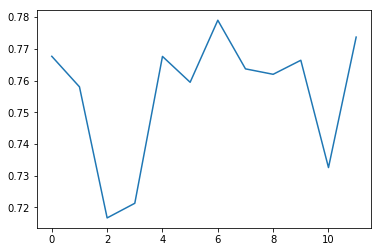

In [41]:
plt.plot(history.history['val_categorical_accuracy'])

In [33]:
plt.savefig(path_to_save_model+'.png')

In [42]:
fname = datafolder.split('/', 3 )[2]

In [48]:
#fname = 'nikolay_im'

In [43]:
res = np.zeros([2,numiter]);

for j in range(numiter):
    model = load_model(path_to_save_model+'_'+str(j))

    eeg_data = test_datas[fname]['eeg_data'].T
    idxs = np.arange(0,eeg_data.shape[1],slice_len)
    num_chunks = idxs.shape[0]

    chunks = np.zeros([num_chunks-1,24,slice_len])
    preds = np.zeros([num_chunks-1,3])

    for i in range(num_chunks-1):
        #print(idxs[i])
        chunk = eeg_data[:,idxs[i]:(idxs[i]+slice_len)].T
        chunks[i,:,:] = chunk.T
        preds[i] = model.predict(chunk[None,:,:,])

    a = np.argmax(preds,axis=1)

    a_bin = np.zeros([3,a.shape[0]])

    a_bin[0,:] = (a == 0)
    a_bin[1,:] = (a == 1)
    a_bin[2,:] = (a == 2)

    true_labels = test_datas[fname]['labels']
    true_labels = true_labels[::slice_len]
    true_labels = true_labels[0:-1]

    true_labels_bin = np.zeros([3,true_labels.shape[0]])

    true_labels_bin[0,:] = (true_labels == 1)
    true_labels_bin[1,:] = (true_labels == 2)
    true_labels_bin[2,:] = (true_labels == 6)

    from sklearn.metrics import roc_auc_score

    score1 = roc_auc_score(true_labels_bin,a_bin)
    #print(score1)

    predsT = preds.T;
    score2 = roc_auc_score(true_labels_bin,predsT)
    print(score1,score2)

    res[0,j] = score1;
    res[1,j] = score2;



C:\Users\voxxys\Anaconda3\lib\site-packages\keras\engine\topology.py:1242: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


ValueError: The model expects 2 arrays, but only received one array. Found: array with shape (1, 250, 24)

In [ ]:
res_av = np.mean(res,axis = 1)
print(res_av)

In [286]:
#filename = 'data/ksenia_long_2test'
#filename = 'data/ksenia_long_1'
#[eeg_data, states_labels, sampling_rate, chan_names, chan_numb, samp_numb, states_codes] = open_eeg_mat(filename, centered=False)
#sampling_rate = sampling_rate[0,0]
#eeg_data = butter_bandpass_filter(eeg_data, 0.5, 45, sampling_rate, order=5, how_to_filt = 'simultaneously')

#states_labels = states_labels[0]
#print(states_labels)
#states_labels = states_labels[2000:-2000]
#eeg_data = eeg_data[:,2000:-2000]


In [71]:
eeg_data = test_datas['ksenia_long']['eeg_data'].T
idxs = np.arange(0,eeg_data.shape[1],slice_len)
num_chunks = idxs.shape[0]
num_chunks

261

In [24]:
chunks = np.zeros([num_chunks-1,24,slice_len])
preds = np.zeros([num_chunks-1,3])

for i in range(num_chunks-1):
    #print(idxs[i])
    chunk = eeg_data[:,idxs[i]:(idxs[i]+slice_len)].T
    chunks[i,:,:] = chunk.T
    preds[i] = model.predict(chunk[None,:,:,])


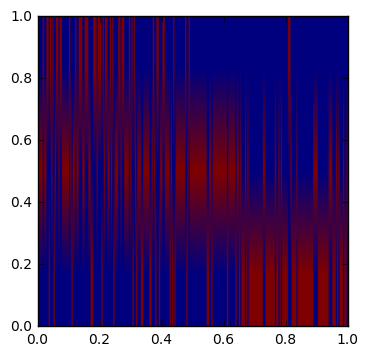

In [25]:
a = np.argmax(preds,axis=1)

a_bin = np.zeros([3,a.shape[0]])

a_bin[0,:] = (a == 0)
a_bin[1,:] = (a == 1)
a_bin[2,:] = (a == 2)
              
plt.imshow(a_bin, extent=[0, 1, 0, 1])

In [26]:
print(preds.shape)
print(a.shape)

true_labels = test_datas['ksenia_long']['labels']
true_labels = true_labels[::slice_len]
true_labels = true_labels[0:-1]
print(true_labels.shape)

true_labels_bin = np.zeros([3,true_labels.shape[0]])
print(true_labels_bin.shape)

true_labels_bin[0,:] = (true_labels == 1)
true_labels_bin[1,:] = (true_labels == 2)
true_labels_bin[2,:] = (true_labels == 6)


(260, 3)
(260,)
(260,)
(3, 260)


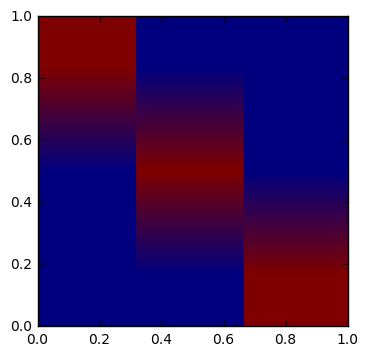

In [27]:
plt.imshow(true_labels_bin, extent=[0, 1, 0, 1])

In [28]:
from sklearn.metrics import roc_auc_score

score1 = roc_auc_score(true_labels_bin,a_bin)
print(score1)

predsT = preds.T;
score2 = roc_auc_score(true_labels_bin,predsT)
print(score2)

0.723076923077
0.771153846154


In [29]:
print(true_labels_bin.shape)
print(a_bin.shape)

(3, 260)
(3, 260)


NameError: name 'roc_auc_score' is not defined

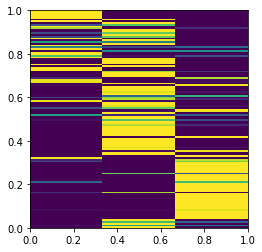

In [64]:
plt.imshow(preds, extent=[0, 1, 0, 1])

In [58]:
model.layers

from matplotlib import pyplot as plt

from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_class_activation


# Build the VGG16 network with ImageNet weights
#model = VGG16(weights='imagenet', include_top=True)
#print('Model loaded.')

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'dense_2'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

model.layers[3]

idx = 2;
img = visualize_class_activation(model, layer_idx, filter_indices=idx, max_iter=500)

img.shape

plt.imshow(img, extent=[0, 1, 0, 1])

img = utils.draw_text(img, str(idx))

idx_list = [1]*20
idx_list


# Generate three different images of the same output index.
vis_images = []
idx_list = [1]*3
for idx in idx_list: #[0, 0, 0]:
    img = visualize_class_activation(model, layer_idx, filter_indices=idx, max_iter=500)
    #img = utils.draw_text(img, str(idx))
    vis_images.append(img)

plt.imshow(vis_images[0], extent=[0, 1, 0, 1])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from vis.utils import utils
#from vis.utils.vggnet import VGG16
from vis.visualization import *

from mne.viz import plot_topomap
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
model.layers

In [ ]:
layer_name = 'dense_3'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

idx = 0;

img = visualize_class_activation(model, layer_idx, filter_indices=idx, max_iter=500)
img_sum = np.sum(img,axis = 0)

testmat = loadmat('chanlocs')
ifvis = testmat['ifvis']
ifvis = ifvis[0]
ifvis = (ifvis == 1)
chanlocs = testmat['chanlocs_xy'].T
chanlocs_m = chanlocs[:,[-1,-2]]
chanlocs_m[:,-2] = -chanlocs_m[:,-2]
img_sum_vis = img_sum[ifvis]

plot_topomap(img_sum_vis,chanlocs_m)